In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster, LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from preprocess import *
from add_features import *
from models import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [ ]:
def treat_nan_sts_peres(sts_peres_df):
    sts_peres_df = sts_peres_df.loc[sts_peres_df['Identifiant arc']==191,:]
    sts_peres_df['Date et heure de comptage'] = pd.to_datetime(sts_peres_df['Date et heure de comptage'], errors='coerce', utc=True)
    sts_peres_df = sts_peres_df.sort_values(by=['Date et heure de comptage'])
    cutoff = pd.Timestamp('2025-10-22 00:00:00', tz='Europe/Paris')

# Filtrer les lignes >= cutoff
    sts_peres_df_1 = sts_peres_df[
    sts_peres_df['Date et heure de comptage'] >= cutoff
].reset_index(drop=True)

    cutoff = pd.Timestamp('2024-11-12 04:00:00', tz='Europe/Paris')

# Filtrer les lignes >= cutoff
    sts_peres_df_2 = sts_peres_df[
    sts_peres_df['Date et heure de comptage'] <= cutoff
].reset_index(drop=True)

    sts_peres_df = pd.concat([sts_peres_df_1,sts_peres_df_2],axis=0)

    return sts_peres_df

sts_peres_df = treat_nan_sts_peres(sts_peres_df)

In [4]:
# champs_elysees_df.isna().sum()/champs_elysees_df["Identifiant arc"].count()

In [5]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 45)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event,Débit horaire_outlier_iqr,Taux d'occupation_outlier_iqr
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-03-16 02:00:00,4264,AV_Champs_Elysees,1068.0,13.31000,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-09-23 16:00:00,4264,AV_Champs_Elysees,903.0,26.75000,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,17.7,3.0,1016.1,100.0,12.0,0.0,NaN,False,False,False
2025-05-12 22:00:00,4264,AV_Champs_Elysees,651.0,13.91167,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-08-18 11:00:00,4264,AV_Champs_Elysees,736.0,13.35889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-05-25 21:00:00,4264,AV_Champs_Elysees,900.0,25.26611,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,La Liga : Athletic Club vs FC Barcelona,True,False,False


In [4]:
df_champs_lstm=pipeline(sts_peres_df, window=3, fill_hours=False,fillna=True)
df_champs_xgb = pipeline(sts_peres_df,window=3,fill_hours=False,fillna=True)

# LSTM Forecasting

In [ ]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False,
    use_outliers=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_lisse)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=10, batch_size=32
)
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [ ]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

# XGBoost model

In [5]:
from src.xgb_forecasting import XGBoostModel

Train set: (1033, 25), Test set: (72, 25) (72 hours)
Débit horaire : RMSE = 42.19, Mean = 435.67, Relative Error = 9.68%
Taux d'occupation : RMSE = 1.48, Mean = 5.70, Relative Error = 25.96%


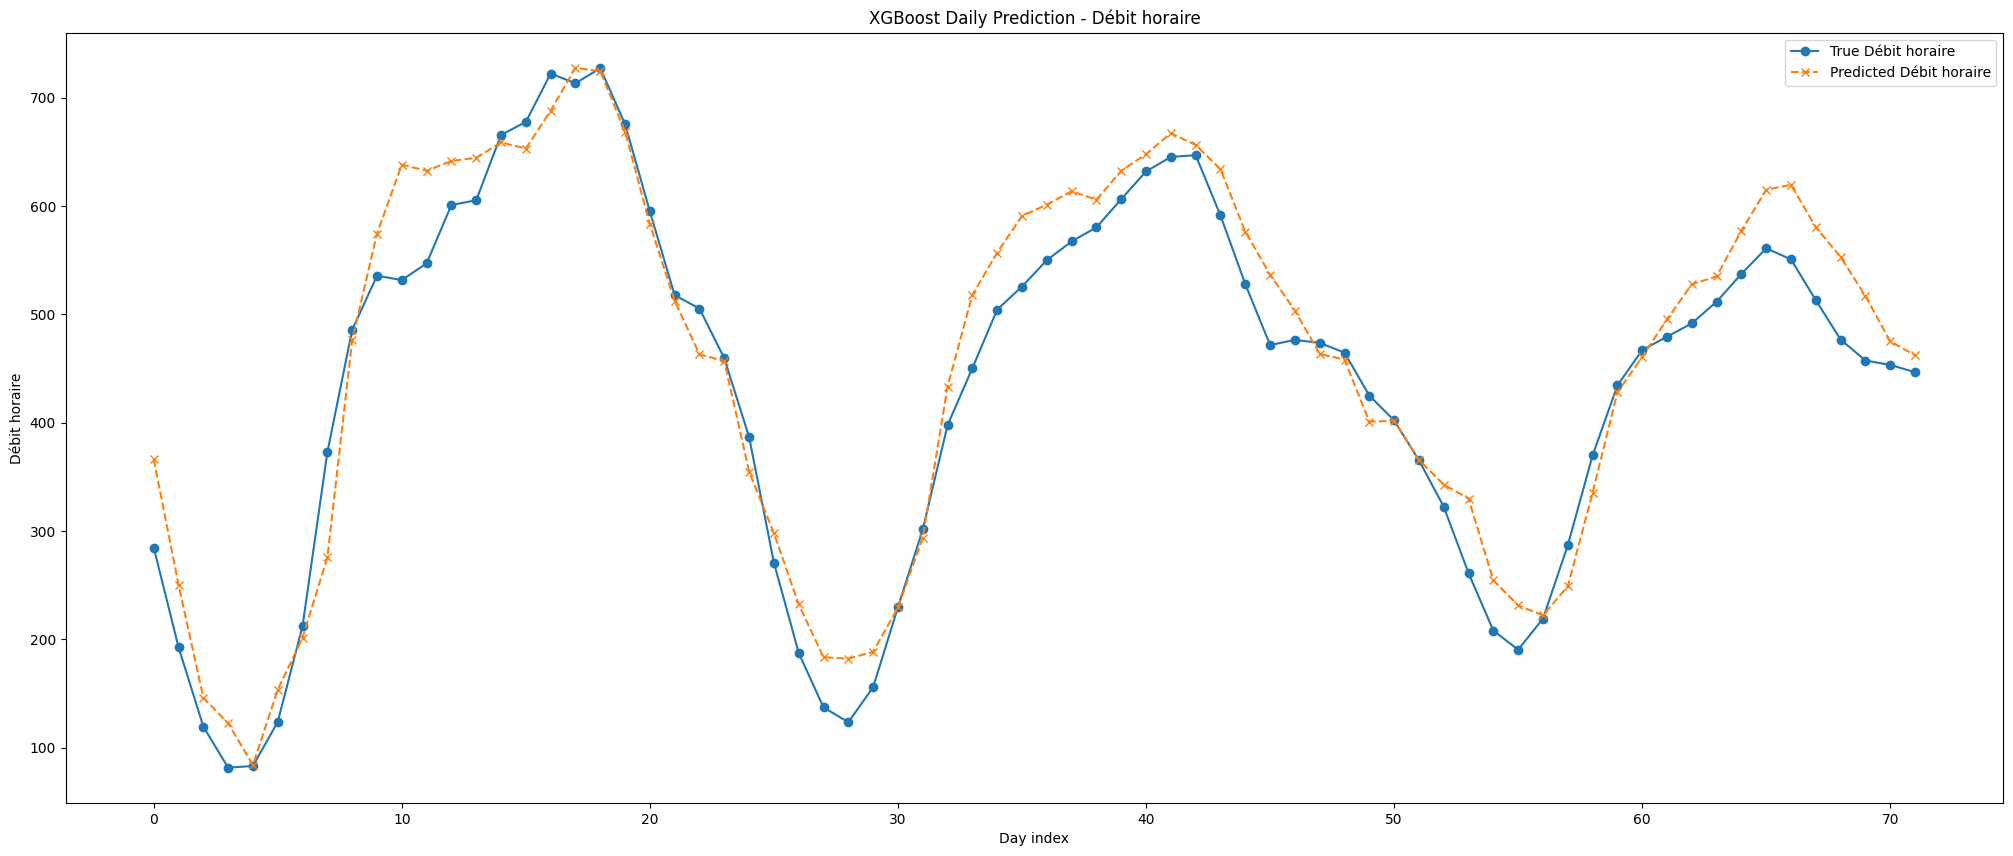

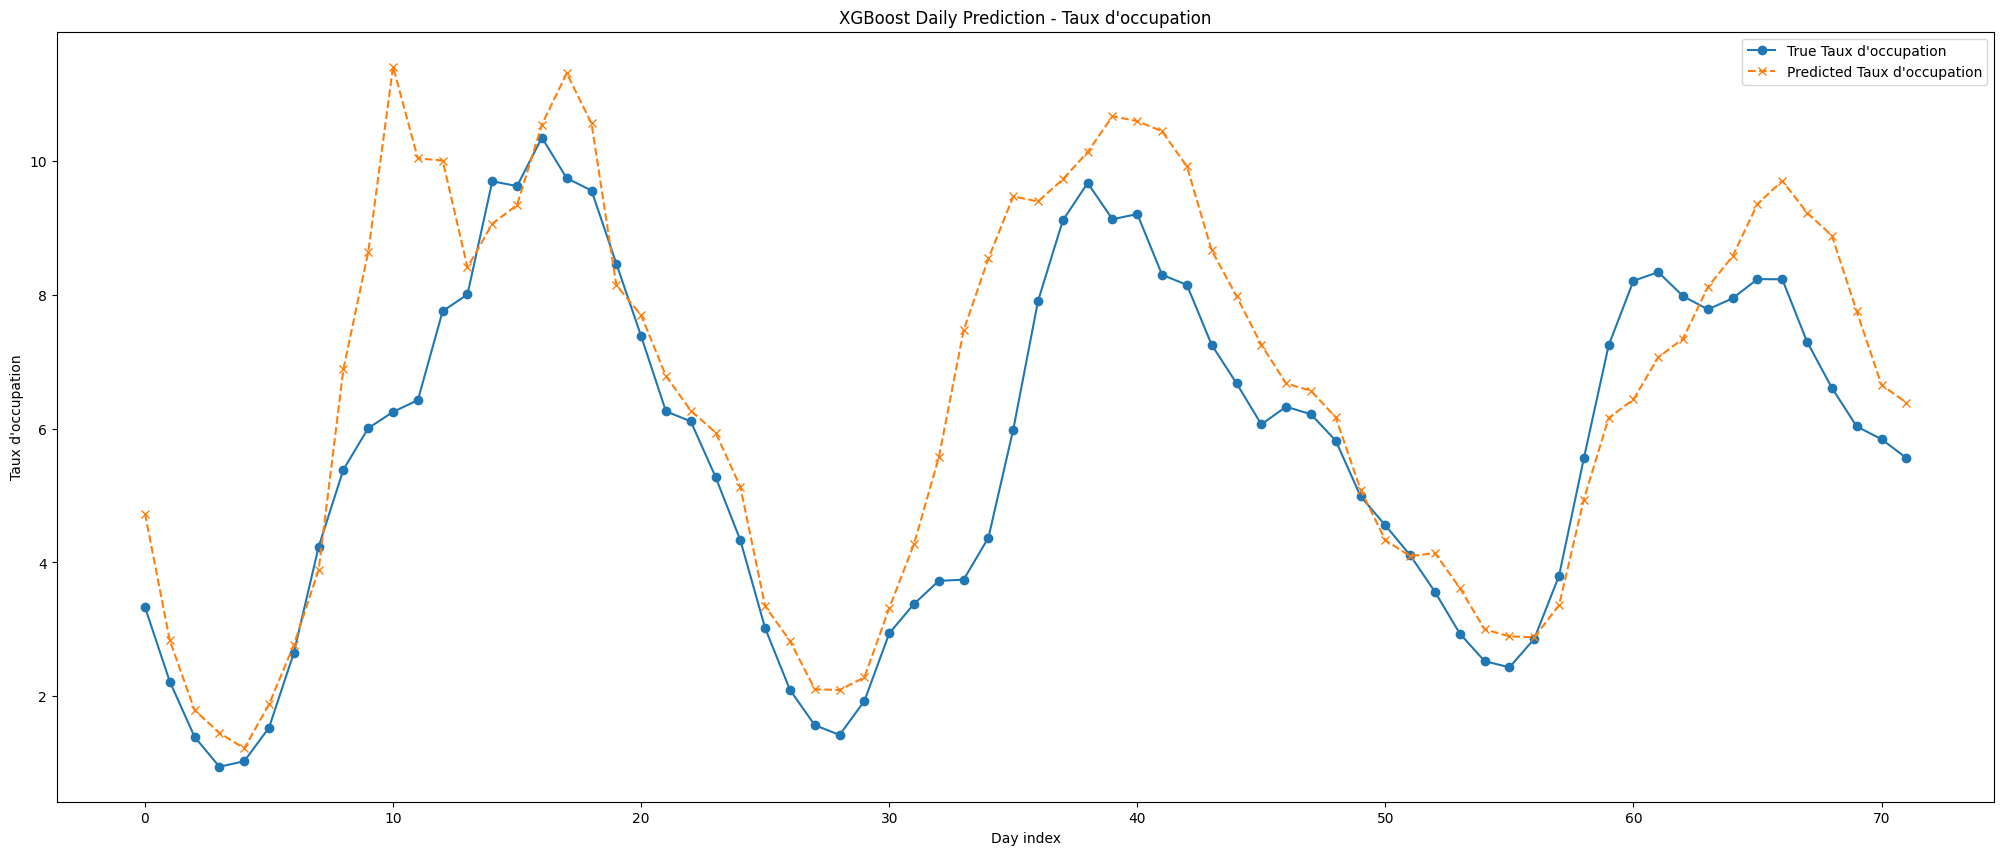

In [6]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb = df_champs_xgb.copy()

# Lags à créer (en heures)
lags_hours = [72,168]  # 1h, 3h, 1 jour, 2 jours, 1 semaine

for target in targets:
    for lag in lags_hours:
        col_name = f"{target}_lag_{lag}h"
        df_xgb[col_name] = df_xgb[target].shift(lag)
        features_xgb.append(col_name)

# Supprimer les lignes contenant des NaN générés par les lags
df_xgb = df_xgb.dropna(subset=[f"{t}_lag_{lag}h" for t in targets for lag in lags_hours] + targets).copy()


xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(25,10))
    plt.plot(y_test[:, i], label=f"True {target}",marker="o")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}",marker="x")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [7]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 101.19, std = 56.54 | MAE mean = 74.66, std = 42.28 | MAPE mean = 25.23%, std = 17.22%
Taux d'occupation : CV RMSE mean = 2.35, std = 0.62 | MAE mean = 1.74, std = 0.49 | MAPE mean = 37.15%, std = 15.54%


In [16]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 177.67, std = 23.58
Taux d'occupation : CV RMSE mean = 7.31, std = 1.64


# Hybrid LSTM + XGBoost model 

In [10]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']


df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

features_xgb += ['lag_1d', 'lag_1w']


# Instanciate XGBoost
xgb_model = XGBoostModel(df_xgb, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0111 - val_loss: 0.0110
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
Train set: (1417, 8), Test set: (72, 8) (72 hours)


In [11]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.3
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
LSTM Prediction Array Shape : (1678, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 265.06, Mean = 772.65, Relative Error = 34.31%
Taux d'occupation : RMSE = 9.53, Mean = 17.08, Relative Error = 55.82%


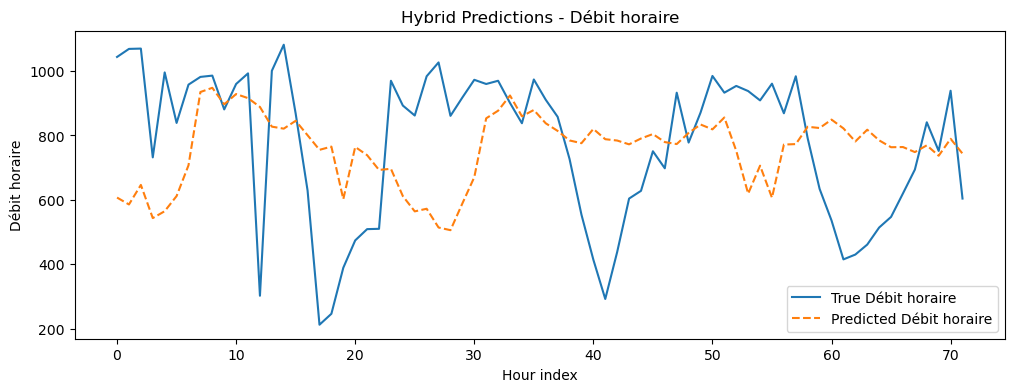

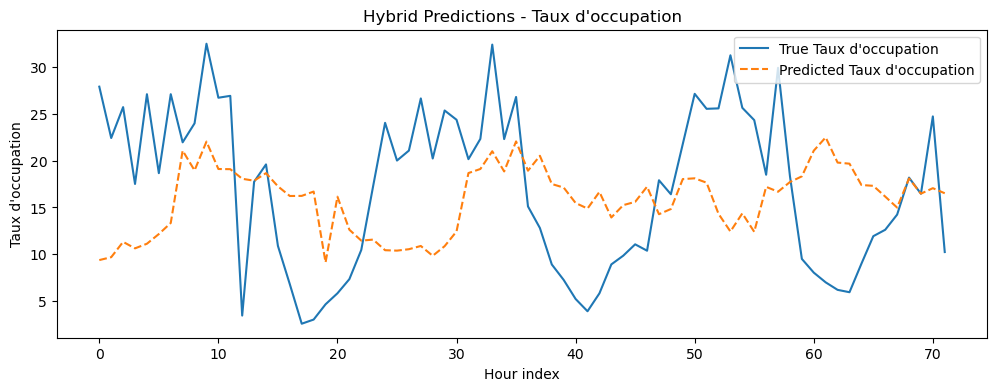

In [12]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()

In [8]:
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

features = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]


In [9]:
final_eval_size = 72
seq_length = 168

# On garde les 168h avant la période finale pour le contexte
context_start = -(seq_length + final_eval_size)
context_end = -final_eval_size

train_val_df = df_champs_lstm.iloc[:-final_eval_size].copy()   # tout ce qui est AVANT le contexte
#context_df = df_champs.iloc[context_start:context_end].copy()  # les 168h de contexte
final_eval_df = df_champs_lstm.iloc[-final_eval_size:].copy()       # les 72h à prédire

print(f"Train: {train_val_df.shape},  Eval: {final_eval_df.shape}")

lstm_model = LSTMTimeSeries(
    features=features,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

Train: (1201, 53),  Eval: (72, 53)


In [19]:
df_champs_orig=pipeline(sts_peres_df, window=0, fill_hours=True)
df_or = df_champs_orig.iloc[:-final_eval_size].copy()
lstm_model.cross_validate(train_val_df,df_or,epochs=30,batch_size=32)

1273
9525
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

===== Fold 1 =====
Débit horaire             RMSE: 112.11, MEAN: 516.88, MAPE: 31.63%, RMSE/mean: 21.69%
Taux d'occupation         RMSE: 2.91, MEAN: 8.33, MAPE: 60.97%, RMSE/mean: 34.92%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

===== Fold 2 =====
Débit horaire             RMSE: 105.03, MEAN: 468.15, MAPE: 35.88%, RMSE/mean: 22.43%
Taux d'occupation         RMSE: 2.18, MEAN: 6.93, MAPE: 63.16%, RMSE/mean: 31.46%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

===== Fold 3 =====
Débit horaire             RMSE: 142.51, MEAN: 444.14, MAPE: 55.76%, RMSE/mean: 32.09%
Taux d'occupation         RMSE: 2.33, MEAN: 6.61, MAPE: 60.89%, RMSE/mean: 35.22%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

===== Fold 4 =====
Débit horaire             RMSE: 178.11, MEAN: 417.79, MAPE: 112.02%, RMSE/mean: 42.63%
Taux d'occupation         RMSE: 3.21, MEAN: 6.84, MAPE: 107.79%, RMSE/mean: 46.94%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

===== Fold 5 =====
Débit horaire             

In [12]:
lstm_model.train_final(train_val_df, epochs=30, batch_size=32)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.9124 - mae: 0.8078 - mape: 114.7635
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4046 - mae: 0.4942 - mape: 150.9988
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.2376 - mae: 0.3725 - mape: 134.2193
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2002 - mae: 0.3381 - mape: 121.0815
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1809 - mae: 0.3174 - mape: 112.7297
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1676 - mae: 0.3043 - mape: 108.3028
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.1565 - mae: 0.2921 - mape: 103.2753
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.1519 - mae: 0.2875 - mape: 101.5271
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1432 - mae: 0.2787 - mape: 97.5263
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.1368 - mae: 0.2725 - mape: 96.3429
Epoch 11/30
31/31 ━━━━━━━━━━━━━

In [13]:
y_pred = lstm_model.predict(train_val_df[-168:])  # entrée : les 168 dernières heures avant la période finale

print("\n📊 Évaluation finale par target :")
for i, target_name in enumerate(targets):
    y_true_i = final_eval_df[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step

📊 Évaluation finale par target :
Débit horaire             RMSE: 60.85, MEAN: 435.67, MAPE: 17.38%, RMSE/mean: 13.97%
Taux d'occupation         RMSE: 1.84, MEAN: 5.70, MAPE: 30.81%, RMSE/mean: 32.21%


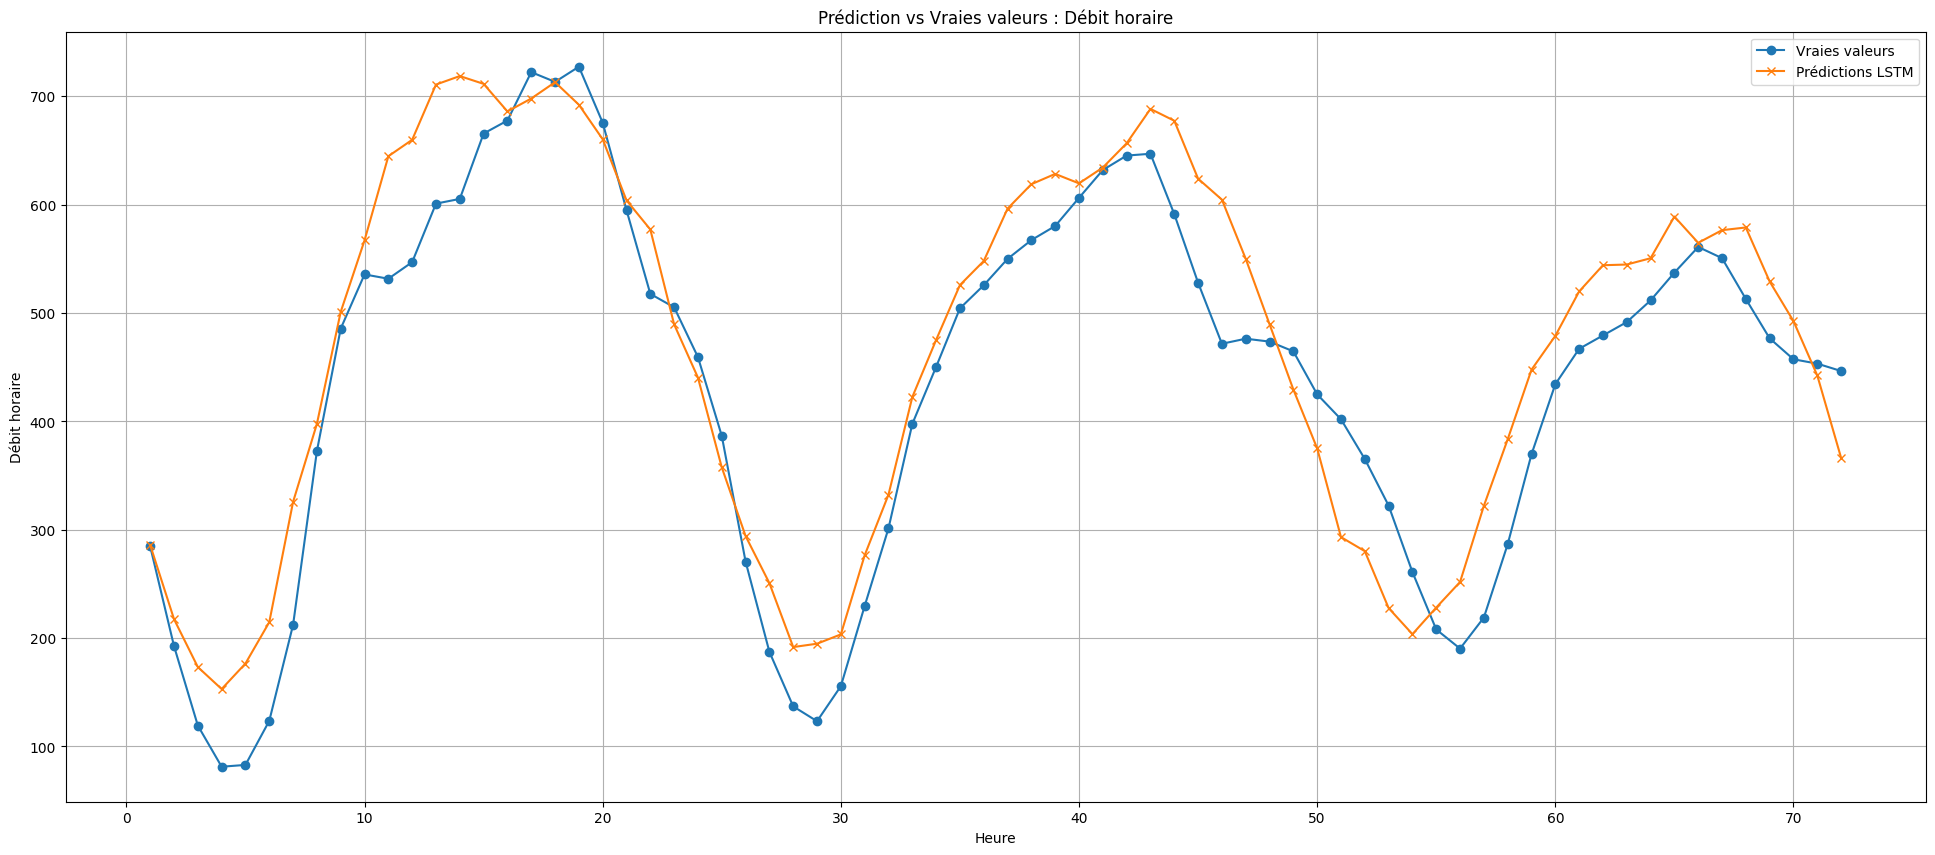

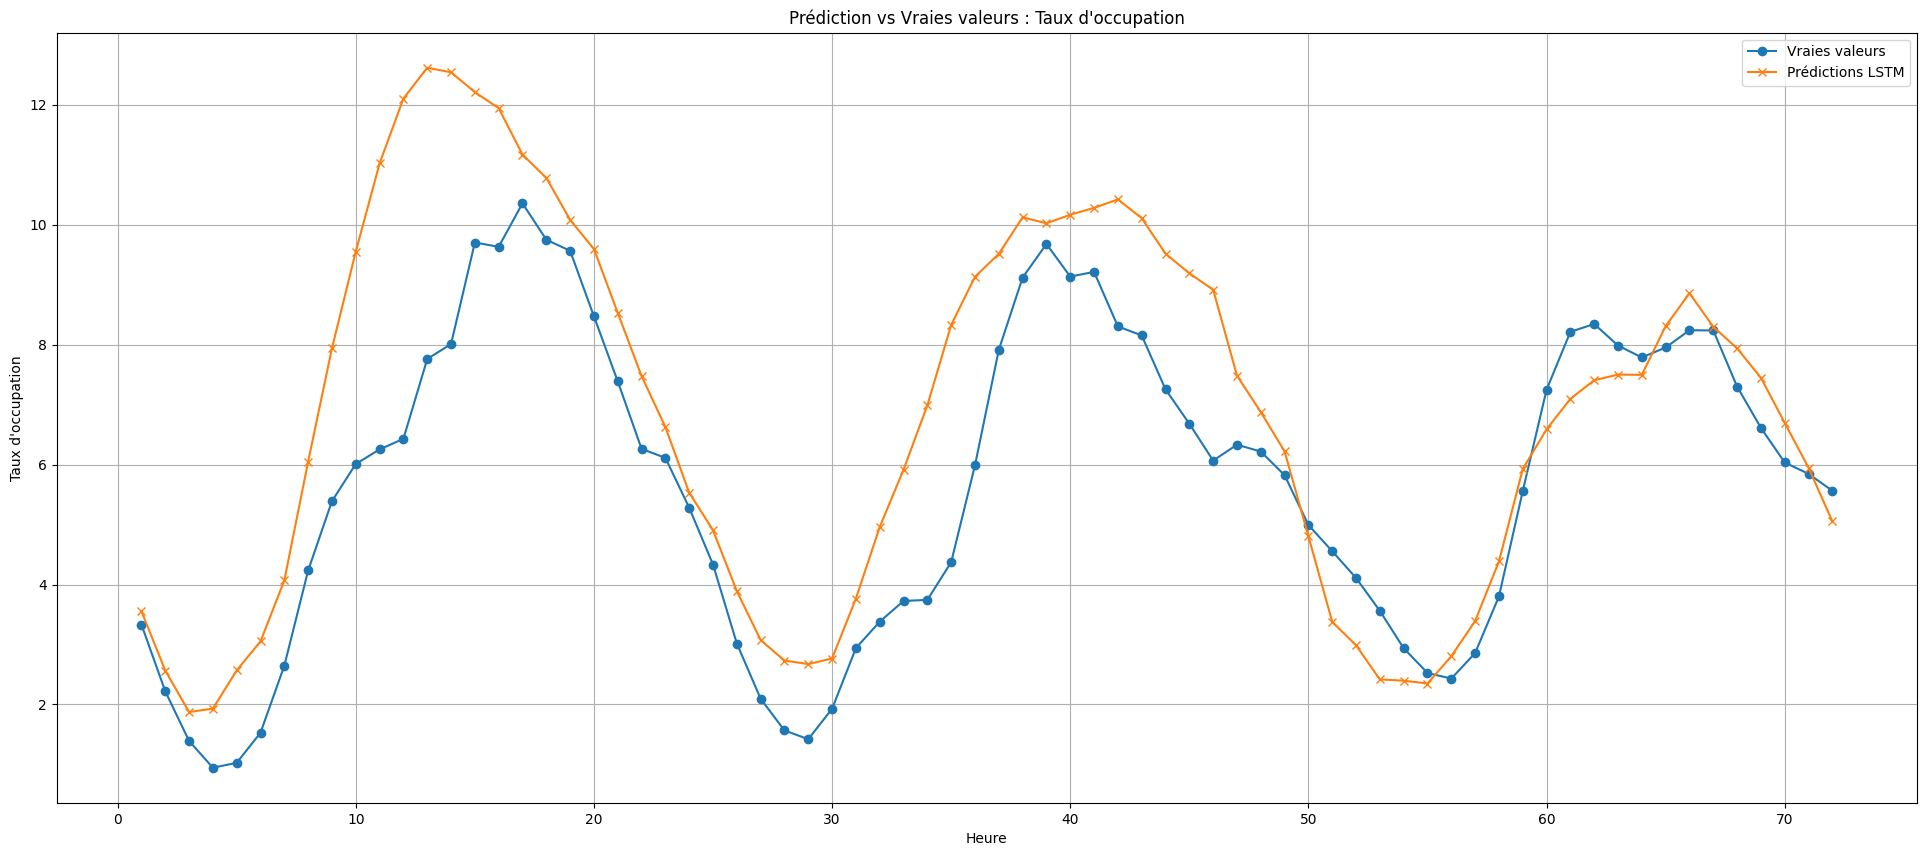

In [14]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()


In [17]:
df_champs_orig=pipeline(sts_peres_df, window=0, fill_hours=True)
df_champs_orig_last = df_champs_orig.iloc[-72:,:]
print("\n📊 Évaluation finale par target (sans fuite de données) :")
for i, target_name in enumerate(targets):
    y_true_i = df_champs_orig_last[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1273
9525

📊 Évaluation finale par target (sans fuite de données) :
Débit horaire             RMSE: 71.46, MEAN: 435.24, MAPE: 22.47%, RMSE/mean: 16.42%
Taux d'occupation         RMSE: 1.94, MEAN: 5.70, MAPE: 36.29%, RMSE/mean: 34.09%


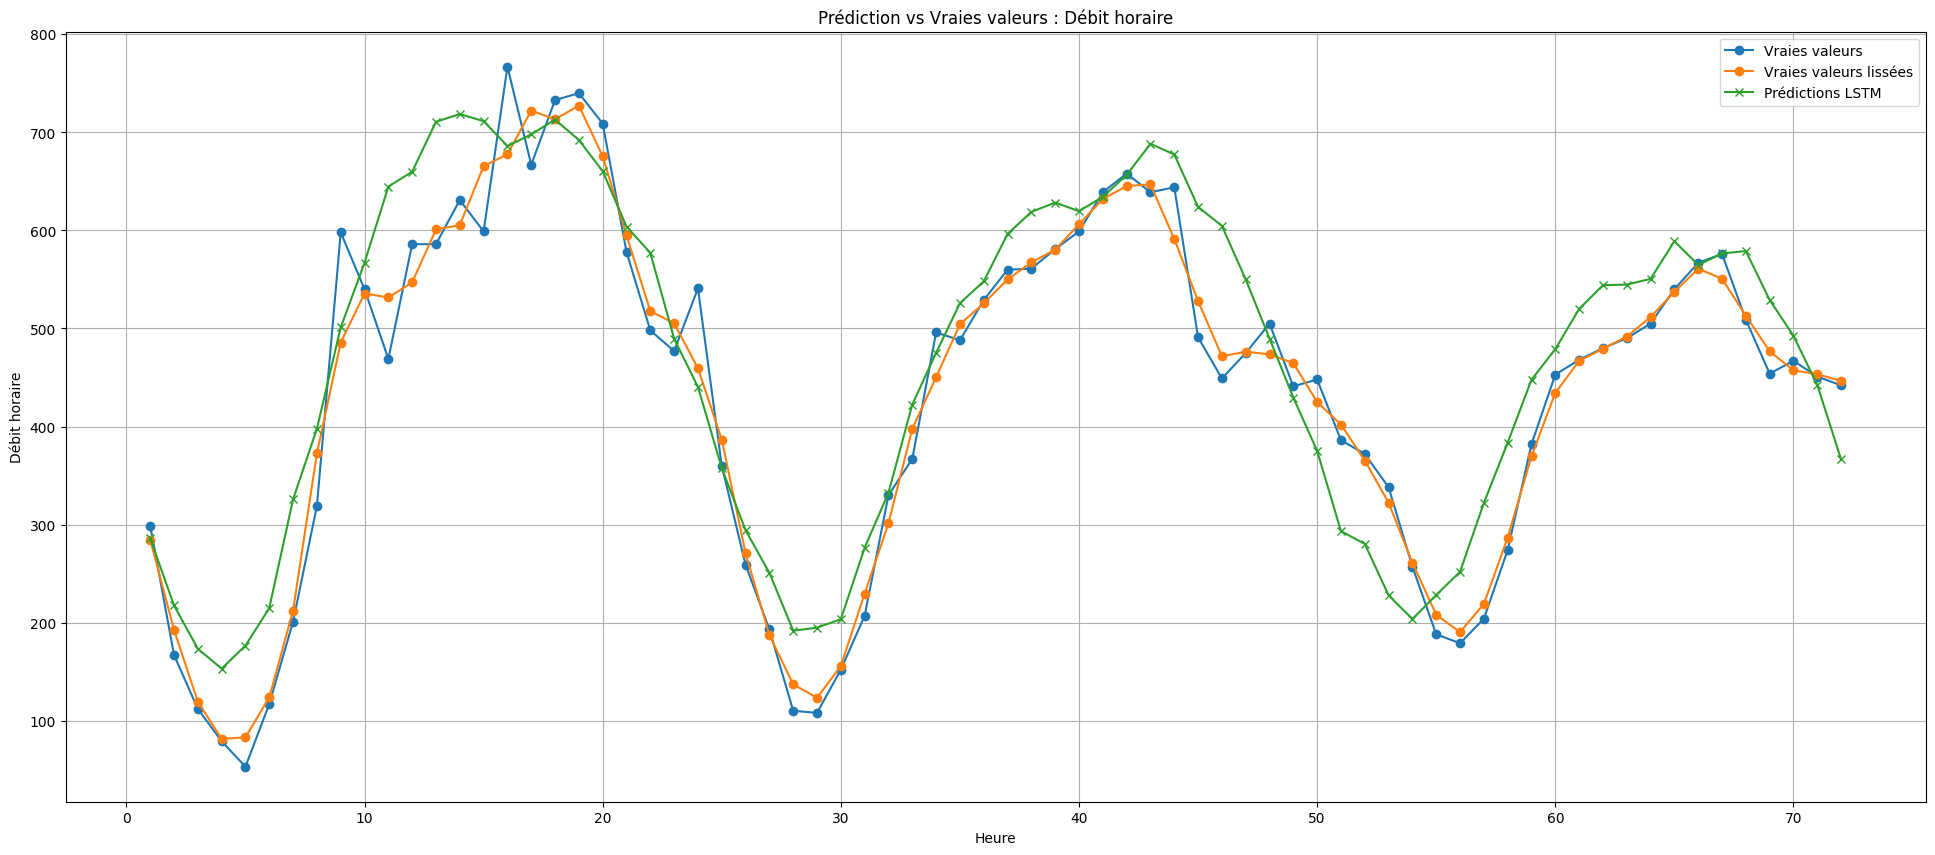

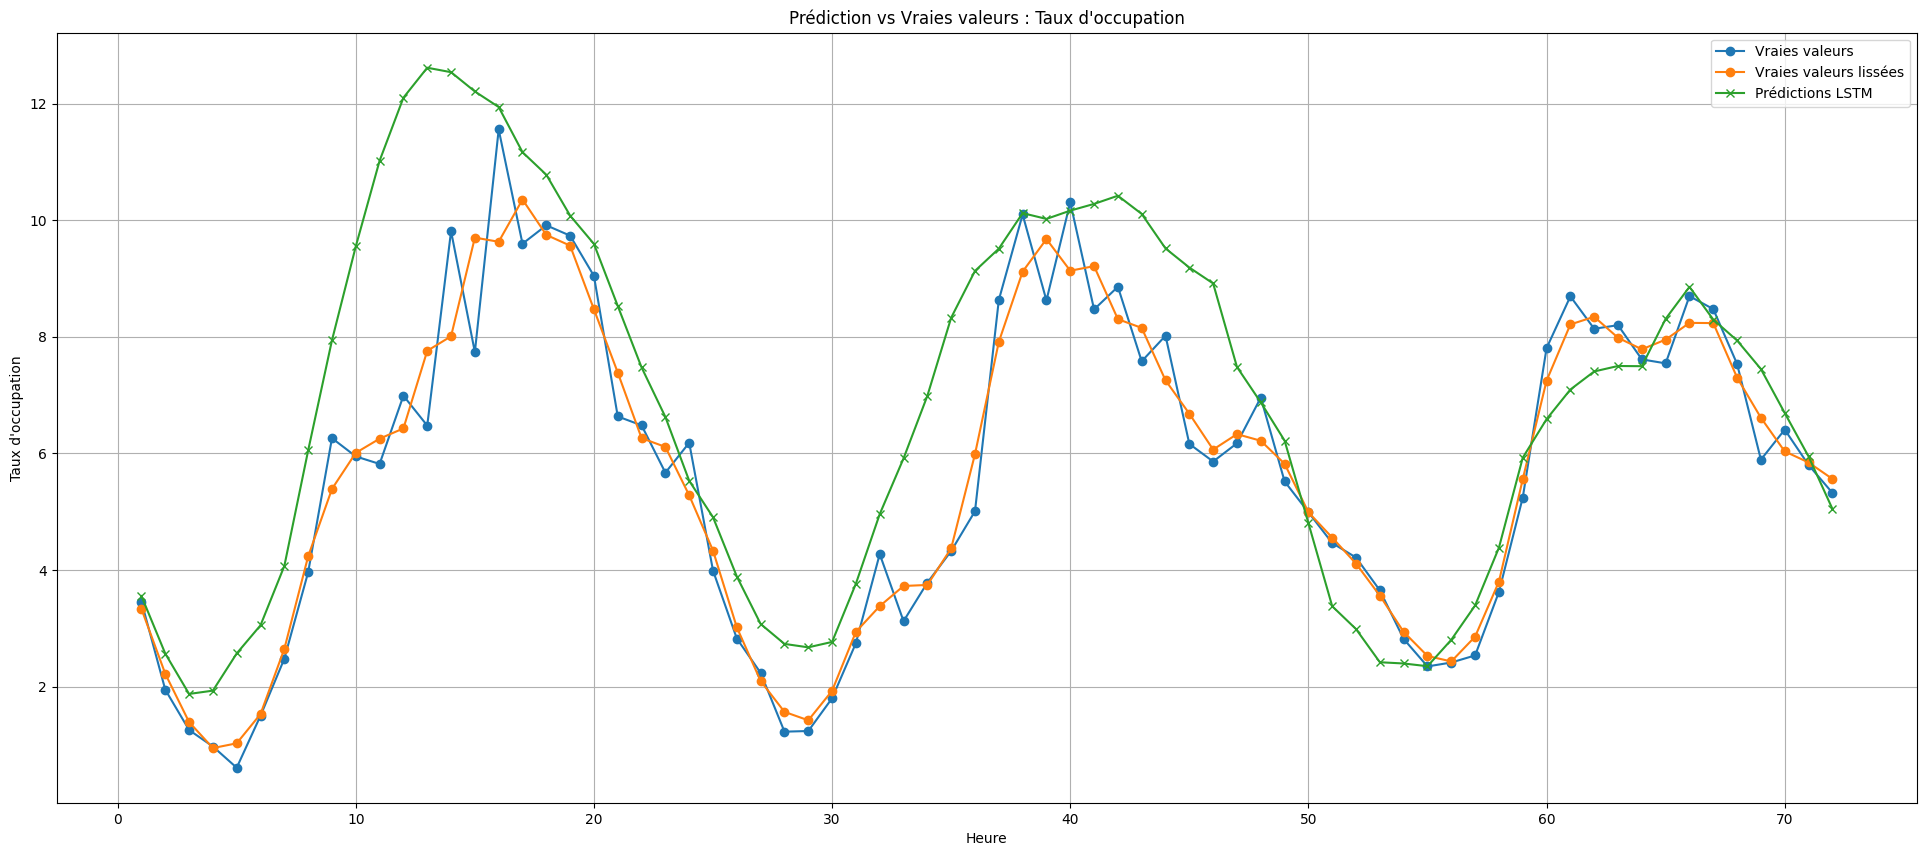

In [18]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, df_champs_orig_last[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs lissées')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()